In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
# Define values for rate constants (k)
k1 = 100000000       # kon for E + S to ES
k2 = 100       # koff for ES to E + S
k3 = 100000000       # kon for E + I to non-covalent EI
k4 = 10       # koff for EI to E + I
k5 = 0.001       # kon for EI to covalent EI*
k6 = 0.0001       # koff for covalent EI* to non-covalent EI
kcat = 1    # kon ES to E+P

# Define concentrations at start of measurement t=0 (before addition of inhibitor or substrate)
E0 = 1*10**-12  #Unbound enzyme concentration E
ES0 = 0                 #Noncovalent enzyme-substrate complex ES
P0 = 0                   #Product
EI0 = 0                 #Non-covalent enzyme-inhibitor complex EI
EIi0 = 0                #Covalent enzyme-inhibitor complex (EI*) 

#Define assay constants
Is = [1*10**-6, 0.5*10**-6, 0.25*10**-6, 0.15*10**-6, 0.075*10**-6, 0.04*10**-6, 0.02*10**-6, 10*10**-9, 5*10**-9, 2.5*10**-9, 1.0*10**-9, 0*10**-9] # List of inhibitor concentrations. Is assumed to be constant, which is only true if inhibitor concentration is >10*E0.
S0 = 10000*10**-9 # Substrate concentration. Is assumed to be constant, which is only true if substrate conversion is less than 10%
dt = 0.0009 # Seconds per simulation step (dt). Minimum value for dt defined by k1*S0*dt < 1 and k3*I0*dt < 1

tframe = 60 # Save a frame every 'tframe' seconds
tincub = 600 # Preincubate with inhibitor for 'tincub' seconds
tsub = 600 # Run with substrate for 'tsub' seconds

In [46]:
all_conc = []
all_t0 = []
all_t1 = []
for I in Is: # Loop over all I's
    all_conc.append(np.array([E0, ES0, P0, EI0, EIi0], dtype=np.double)) #matrix van concentraties
    # Voor toevoeging van S

    S=0 # Geen S in je systeem
        
                            # [         E,       ES, P,     EI, EI*]
    all_t0.append(np.array([[-k3*I-k1*S,  k2+kcat, 0,     k4,   0],  #E
                            [      k1*S, -k2-kcat, 0,      0,   0],  #ES
                            [         0,     kcat, 0,      0,   0],  #P
                            [      k3*I,        0, 0, -k4-k5,  k6],  #EI
                            [         0,        0, 0,     k5, -k6]]).T) #EI*

    # Change in E   = [E]*(-k3*I-k1*S) + [ES]*(k2+kcat)  + [P]*(0) + [EI]*(k4)     + [EI*]*(0)
    # Change in ES  = [E]*(k1*S)       + [ES]*(-k2-kcat) + [P]*(0) + [EI]*(0)      + [EI*]*(0)
    # Change in P   = [E]*(0)          + [ES]*(kcat)     + [P]*(0) + [EI]*(0)      + [EI*]*(0)
    # Change in EI  = [E]*(k3*I)       + [ES]*(0)        + [P]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
    # Change in EI* = [E]*(0)          + [ES]*(0)        + [P]*(0) + [EI]*(k5)     + [EI*]*(-k6)


    #Na toevoeging van S
    S= S0
    all_t1.append(np.array([[-k3*I-k1*S, k2+kcat, 0, k4, 0],
                            [k1*S, -k2-kcat, 0, 0, 0],
                            [0, kcat, 0, 0, 0],
                            [k3*I, 0, 0, -k4-k5, k6],
                            [0, 0, 0, k5, -k6]]).T)
    # Maak een lijst van kopien van de concentraties
concentraties = np.stack(all_conc)  
t0 = np.stack(all_t0)
t1 = np.stack(all_t1)                
plot = [concentraties.copy()]

tijdconc = concentraties.copy()
t = 0
# Voor toevoging van S (tincub/dt stappen = 30min)
for i in range(int(tincub/dt)):
    t+= 1
    tijdconc += np.dot(tijdconc, t0*dt).diagonal().T
    #tijdconc += [diff[i].T[i] for i in range(len(Is))] # Doe 1 dt tijdstap
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

      # Na toevoeging van S (tsub/dt stappen)
for i in range(int(tsub/dt)):
    t += 1
    tijdconc += np.dot(tijdconc, t1*dt).diagonal().T   
    if (tijdconc < 0).any():
      raise ValueError("got a negative concentration, try decreasing dt")

    
    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

In [47]:
all_plots = np.array(plot).swapaxes(0,1) #swap ax 0 and ax 1

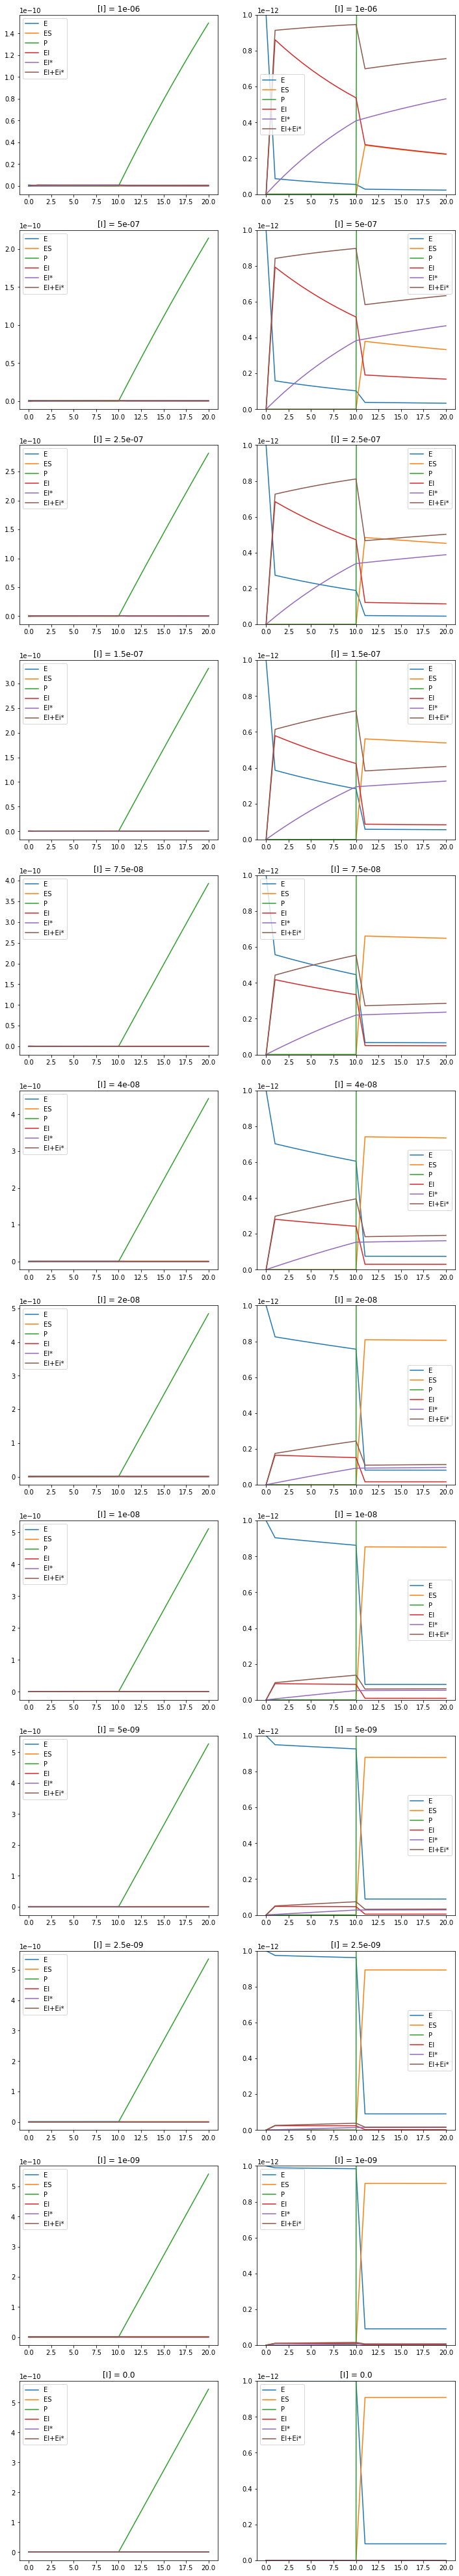

In [48]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, ES, P, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    
   # Plot de figuren
  labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "ES":ESplot, "P":Pplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [49]:
df


0.000001                              ... 0.000000                            
               E            EI           EIi  ...      EIi            ES             P
0   1.000000e-12  0.000000e+00  0.000000e+00  ...      0.0  0.000000e+00  0.000000e+00
1   8.609900e-14  8.609823e-13  5.291873e-14  ...      0.0  0.000000e+00  0.000000e+00
2   8.157009e-14  8.156936e-13  1.027363e-13  ...      0.0  0.000000e+00  0.000000e+00
3   7.730724e-14  7.730655e-13  1.496273e-13  ...      0.0  0.000000e+00  0.000000e+00
4   7.329483e-14  7.329418e-13  1.937634e-13  ...      0.0  0.000000e+00  0.000000e+00
5   6.951814e-14  6.951752e-13  2.353066e-13  ...      0.0  0.000000e+00  0.000000e+00
6   6.596332e-14  6.596274e-13  2.744092e-13  ...      0.0  0.000000e+00  0.000000e+00
7   6.261734e-14  6.261680e-13  3.112146e-13  ...      0.0  0.000000e+00  0.000000e+00
8   5.946794e-14  5.946743e-13  3.458578e-13  ...      0.0  0.000000e+00  0.000000e+00
9   5.650356e-14  5.650308e-13  3.784657e-13  ...      0.0  0.000000e+00  0.000000e+00
10  5.371333e-14  5.371287e-13  4.091579e-13  ...      0.0  0.000000e+00  0.000000e+00
11  2.758630e-14  2.758508e-13  4.234302e-13  ...      0.0  9.082652e-13  5.448964e-11
12  2.692746e-14  2.692628e-13  4.372002e-13  ...      0.0  9.082652e-13  1.089850e-10
13  2.629109e-14  2.628996e-13  4.505005e-13  ...      0.0  9.082652e-13  1.634804e-10
14  2.567643e-14  2.567534e-13  4.633471e-13  ...      0.0  9.082652e-13  2.179757e-10
15  2.508274e-14  2.508168e-13  4.757555e-13  ...      0.0  9.082652e-13  2.724711e-10
16  2.450930e-14  2.450827e-13  4.877407e-13  ...      0.0  9.082652e-13  3.269665e-10
17  2.395542e-14  2.395443e-13  4.993171e-13  ...      0.0  9.082652e-13  3.814618e-10
18  2.342043e-14  2.341947e-13  5.104986e-13  ...      0.0  9.082652e-13  4.359572e-10
19  2.290369e-14  2.290276e-13  5.212987e-13  ...      0.0  9.082652e-13  4.904526e-10
20  2.240457e-14  2.240368e-13  5.317304e-13  ...      0.0  9.082652e-13  5.449479e-10

[21 rows x 60 columns]

In [50]:
# Printing the values at timepoint
df.iloc[10]

1.000000e-06  E      5.371333e-14
              EI     5.371287e-13
              EIi    4.091579e-13
              ES     0.000000e+00
              P      0.000000e+00
5.000000e-07  E      1.028617e-13
              EI     5.143007e-13
              EIi    3.828376e-13
              ES     0.000000e+00
              P      0.000000e+00
2.500000e-07  E      1.888562e-13
              EI     4.721279e-13
              EIi    3.390160e-13
              ES     0.000000e+00
              P      0.000000e+00
1.500000e-07  E      2.824311e-13
              EI     4.236309e-13
              EIi    2.939380e-13
              ES     0.000000e+00
              P      0.000000e+00
7.500000e-08  E      4.455354e-13
              EI     3.341337e-13
              EIi    2.203309e-13
              ES     0.000000e+00
              P      0.000000e+00
4.000000e-08  E      6.050023e-13
              EI     2.419847e-13
              EIi    1.530130e-13
              ES     0.000000e+00
              

In [51]:
print(df.to_csv())

,1e-06,1e-06,1e-06,1e-06,1e-06,5e-07,5e-07,5e-07,5e-07,5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,7.5e-08,7.5e-08,7.5e-08,7.5e-08,7.5e-08,4e-08,4e-08,4e-08,4e-08,4e-08,2e-08,2e-08,2e-08,2e-08,2e-08,1e-08,1e-08,1e-08,1e-08,1e-08,5e-09,5e-09,5e-09,5e-09,5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,1e-09,1e-09,1e-09,1e-09,1e-09,0.0,0.0,0.0,0.0,0.0
,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P
0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0
1,8.609900446154286e-14,8.609822655404985e-13,5.2918729997964434e-14,0.0,0.0,1.5856684636835924e-13,7.92821098972616e-13,4.861205465902932e-14,0.0,0.0,2.7377501410497507e-13,